# Taxi Networks simulation

In this notebook, we will demonstrate code that simulates the behavior of taxis
in queueing networks. We are modeling this using a Jackson network, which models
taxis as customers traveling in the network. Taxis queue at each station $i$,
and are served by customers arriving at a rate of $\mu_i$. After a customer
gets on a taxi, it travels to another station $j$ with probability
$r_{ij}$. We assume the taxis 

In [1]:
import numpy as np
import scipy.linalg as la
import scipy.stats as sps
from matplotlib import pyplot as plt
%matplotlib inline

Here we define the a Jackson Network Node. 

In [2]:
def make_callable(x):
    return x if callable(x) else lambda _: x

class Node:
    '''A Node object in a Jackson network simulates a queue with an exponential
    service time.'''
    def __init__(self, mu, n, r, dt=1):
        '''
        mu     : Service rate (average vehicles per time), constant or a function
                 of number of vehicles in node
        n      : Number of vehicles in the node
        r      : Routing probability from node id to probability
        dt     : Timestep 
        '''
        self.r = r
        self.check_r()
        self.mu = make_callable(mu) 
        self.dt = dt
        self.n = n  # Number in queue
        
    def check_r(self):
        assert abs(sum(self.r.values()) - 1.0) < 1e-15, 'Routing probabilities do not sum to 1!'

    def add(self, n):
        self.n += n

    def route_to(self):
        '''Samples a destination from the routing probability distribution'''
        p, s = np.random.sample(), 0
        for id, prob in self.r.items():
            s += prob
            if p < s: return id
        print p, s, id, self.r

    def step(self):
        '''Sample cars from Poisson distribution'''
        num_samples = np.random.poisson(lam=self.mu(self.n) * self.dt)
        destinations = [self.route_to() for _ in range(min(self.n, num_samples))]
        self.n = max(self.n - num_samples, 0)
        return destinations

Here we create a node, put 5 cars in it and simulate 5 time steps. Note that no
more destinations are output after all 5 cars in this node has been served.

In [3]:
n1 = Node(2, 5, {'a': 0.2, 'b': 0.3, 'c': 0.5})
[n1.step() for _ in range(5)]

[[], ['a'], ['c'], ['c', 'b', 'a'], []]

In [4]:
def full_network(k, lam, n):
    '''Creates a network of k nodes (fully connected graph) with equal routing
    probabilities and service times, ignoring travel times. Each node starts
    with n vehicles.'''
    prob = 1.0 / (k-1) # Equal probability to go to each node
    network = {}
    for i in range(k):
        network[i] = Node(lam, n, {j: prob for j in range(k) if j != i})
    return network

def linear_network(k, psi, lam, n):
    '''A network of nodes, with a linear virtual passenger chain from node i
    to node i+1, with service rate psi.'''
    lam, psi = make_callable(lam), make_callable(psi)
    nw = full_network(k, lam, n=n)    
    for i, node in nw.items():
        if i == k-1: # Don't alter last node in chain
            continue
        node.mu = lambda x: psi(i) + lam(i)
        for j in node.r:
            newr = float(lam(i) * node.r[j]) / (lam(i) + psi(i))
            if j == i+1:
                newr += float(psi(i)) / (lam(i) + psi(i))
            node.r[j] = newr
        node.check_r()
    return nw

def network_to_matrix(nw):
    n = len(nw)
    res = []
    for i in range(n):
        for j in range(n):
            res.append(nw[i].r.get(j) or 0)
    return np.reshape(res, (n, n)).T

In [5]:
test_nw = linear_network(5, 0.1, 1, 15)
print test_nw[1].r
print test_nw[4].r

{0: 0.22727272727272727, 2: 0.3181818181818182, 3: 0.22727272727272727, 4: 0.22727272727272727}
{0: 0.25, 1: 0.25, 2: 0.25, 3: 0.25}


[8.0958000000000006, 43.594360000000002, 54.317160000000001, 44.671239999999997, 29.618680000000001, 26.49456, 24.205400000000001, 36.865200000000002, 23.337039999999998, 708.80056000000002]


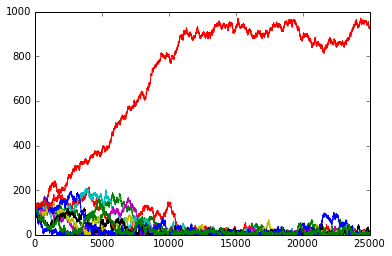

In [6]:
from collections import Counter

def network_tick(network):
    '''Simulates one tick of a network'''
    dest = Counter()
    for node in network.values():
        dest.update(node.step())
    for i, count in dest.items():
        network[i].add(count)

def get_counts(network):
    return zip(*[(i, node.n) for i, node in network.items()])

test_nw = linear_network(10, 0.1, 1, 100)
counts = []
steps = 25000

for _ in range(steps):
    network_tick(test_nw)
    counts.append(get_counts(test_nw)[1])

x = range(steps)
for y in zip(*counts):
    plt.plot(x, y)

print map(np.mean, zip(*counts))

# Sandbox for math

In [27]:
def mva(v, mu, n):
    dim = len(v)
    gamma = v / mu
    L = np.zeros(dim)
    for k in range(1, n+1):
        L1 = np.ones(dim) + L
        f = k / float(gamma.dot(L1))
        L = f * gamma * L1
    return L

def get_first_evac(m):
    evals, evecs = la.eig(m, right=True)
    max_index = max(enumerate(evals), key=lambda x: abs(x[1]))[0]
    return evecs[:,max_index]

p_real = 1
p_virt = 0.0001
n = 5
m = network_to_matrix(linear_network(n, p_virt, p_real, 0))
mu = [(p_real + p_virt)]*(n-1) + [p_real]
print np.round(m, 5)

first_evec = get_first_evac(m)
first_evec /= first_evec[-1]

print first_evec / mu
first_evec = first_evec.astype(float)
print mva(first_evec, mu, n*30)

/usr/lib/python2.7/site-packages/IPython/kernel/__main__.py:27: ComplexWarning: Casting complex values to real discards the imaginary part


[[ 0.       0.24998  0.24998  0.24998  0.25   ]
 [ 0.25007  0.       0.24998  0.24998  0.25   ]
 [ 0.24998  0.25007  0.       0.24998  0.25   ]
 [ 0.24998  0.24998  0.25007  0.       0.25   ]
 [ 0.24998  0.24998  0.24998  0.25007  0.     ]]
[ 0.99984002+0.j  0.99992000+0.j  0.99992001+0.j  0.99992001+0.j
  1.00000000+0.j]
[ 29.93806828  29.99995281  29.99995777  29.99995777  30.06206337]


In [15]:
m = np.array([[0,0,0,0,0.25], [1,0,0,0,0.25], [0,1,0,0,0.25], [0,0,1,0,0.25], [0,0,0,1,0]])

first_evec = get_first_evac(m)
first_evec /= first_evec[-1]
print first_evec


[ 0.25+0.j  0.50+0.j  0.75+0.j  1.00+0.j  1.00+0.j]
